# Reactive air shock
In this report a code to compute the chemical relaxation past a shock is developed. [Aggiungere cose]

Firstly, as python is used, the required packages are imported and global variables are defined.



In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import copy as cp
import scipy.optimize as opt
import scipy.integrate as itg

In [2]:
Kb  = 1.3806503e-23;  # Boltzmann constant [J/K]
amu = 1.66053904020e-24; # 1/Avogadro's number [mol]
Ru = Kb/amu #[J/(K*mol)]

In [3]:
%matplotlib inline

plt.rcParams["figure.figsize"] = (15,10)

#rtol = 1e-3
#atol = 1e-6
rtol = 1e-12
atol = 1e-12
debug = 0

# tolleranze per la soluzione due sistemi

## Specie class definition

For each specie a common framework is defined which allows to compute thermodynamic derivatives, energy, temperature and other relevant values for the subsequent calculations starting from the data provided by Park and Zanardi.

Assuming that the different contributions can be computed indipendently, the temperature and CVs are defined as the sum of the translational-rotational, vibrational and electronic which are calculated as:

* Translational-rotational : 
    1. If the molecule is monoatomic, it has no rotational dofs, then $ CV^t = \frac{3}{2} R_{gas} T $
    2. If the molecule is not monoatomic, the rotational contribution must be added $ CV^{(rt)} = CV^t + R $
    
    Then, energy is computed as $e^{tr} = CV  T$.
    
* Vibrational :
    The contribution of vibrational dofs to energy is computed by assuming armhonic oscillator potential. The energy can becomes: $e^{v} = R_{gas} \frac{\theta_v}{e^{\frac{\theta_v}{T}-1}} $ <br>
    The analytical expression for the heat is computed by deriving with respect to T.
    
* Electronic :
    Given the partition function (Zanardi's tables), the energy due to electronic energy levels is computed as: $ e = R_{gas}T^2 \frac{\partial}{\partial T} log(Z) = \frac{R_gas}{Z} \sum_i g_i \theta_i e^{-\frac{\theta_i}{T}}$.
    
    Analogously with the vibrational contribution the expression for the specific heat is obtained deriving the formula with respect to T.
    
All energies are written as sensible energy whose reference temperature is $T_0 = 293.15 K$

In [4]:
class specie:
    def __init__(self, mmol, th_v, th_r, th_d, h_form = 0):
        self.th_v = th_v
        self.th_r = th_r
        self.th_d = th_d
        self.electro_g = None
        self.electro_th = None
        self.e0 = None
        self.e_rot = None
        self.e_vib = None
        self.e_ele = None
        self.e = None
        self.mmol = mmol*1e-3
        self.R = Kb/(mmol*1e-3)/amu
        self.h_form = h_form
        specie.name = None
        
    def energy(self, T):
        'Computes the energy and Cv as the sum of translational-rotational, vibrational and electronic contributions'
        e = 0
        cv = 0
        T0 = 298.15
        
        # Traslational - rotational 
        if self.th_r > 0:
            cv_rot = 3/2 * self.R + self.R
        else:
            cv_rot = 3/2 * self.R
            
        e_rot  = cv_rot * (T-T0)
        
        # Vibrational 
        if self.th_v > 0:
            cv_vib = self.R*((self.th_v/T)**2)*(np.exp(self.th_v/T))/((np.exp(self.th_v/T)-1)**2)
            e_vib  = self.R*self.th_v/(np.exp(self.th_v/T) - 1) - self.R*self.th_v/(np.exp(self.th_v/T0) - 1)
        else:
            cv_vib = 0
            e_vib  = 0
        
        # Electronic
        Z  = np.sum(self.electro_g * np.exp(-self.electro_th/T))
        Z0 = np.sum(self.electro_g * np.exp(-self.electro_th/T0))
        Z1 = np.sum(self.electro_g * np.exp(-self.electro_th/T) * self.electro_th)
        Z10= np.sum(self.electro_g * np.exp(-self.electro_th/T0) * self.electro_th)
        Z2 = np.sum(self.electro_g * np.exp(-self.electro_th/T) * self.electro_th**2) 
        Z20= np.sum(self.electro_g * np.exp(-self.electro_th/T0) * self.electro_th**2) 
        e_ele  = self.R * Z1 / Z - self.R * Z10 / Z0
        cv_ele = self.R/(T**2)*(-(e_ele/self.R)**2 + Z2 / Z)
        
        # Update Cv and e values
        cv = cv_rot + cv_vib + cv_ele
        e  = e_rot  + e_vib  + e_ele 
        e  = e - self.R * T0                         # Additional term to transform in sensible energy
        e  = e + self.h_form
        
        return e, cv

## Importing species data 
Species are defined as objects of class specie and properties are defined according to the tables in Zanardi.

In [5]:
N2 = specie(28.0134, 3395, 2.9, 113200)
N2.electro_g  = np.array([1, 3, 6, 6, 3, 1, 2, 2, 5, 1, 6, 6, 10, 6, 6])
N2.electro_th = np.array([0.0, 7.2231565e+04, 8.5778626e+04, 8.6050267e+04, 9.5351186e+04, 9.8056357e+04,
                          9.9682677e+04, 1.0489765e+05, 1.1164896e+05, 1.2258365e+05, 1.2488569e+05, 
                          1.2824762e+05, 1.3380609e+05, 1.4042964e+05, 1.5049589e+05])
N2.name = 'N2'

O2 = specie(31.9988, 2239.0, 2.1, 59500)
O2.electro_g = np.array([3, 2, 1, 1, 6, 3, 3])
O2.electro_th= np.array([0, 1.1391560e+04, 1.8984739e+04, 4.7559736e+04, 4.9912421e+04, 5.0922686e+04,
                         7.1898633e+04])
O2.name = 'O2'

O  = specie(15.9994, 0.0, 0.0, 59500, 1.5574e+07)
O.electro_g = np.array([5, 3, 1, 5, 1])
O.electro_th= np.array([0.0, 2.2770776e+02, 3.2656888e+02, 2.2830286e+04, 4.8619930e+04])
O.name = 'O'

N = specie(14.0067, 0, 0, 113200, 3.3747e+07)
N.electro_g = np.array([4, 10, 6])
N.electro_th= np.array([0.0, 2.7664696e+04, 4.1493093e+04])
N.name = 'N'

NO = specie(30.0061, 2817.0, 2.5, 75500, 3.0091e+6)
NO.electro_g = np.array([4, 8, 2, 4, 4, 4, 4, 2, 4, 2, 4, 4, 2, 2, 2, 4])
NO.electro_th= np.array([0.0, 5.4673458e+04, 6.3171396e+04, 6.5994503e+04, 6.9061210e+04, 7.0499985e+04,
                        7.4910550e+04, 7.6288753e+04, 8.6761885e+04, 8.7144312e+04, 8.8860771e+04,
                        8.9817556e+04, 8.9884459e+04, 9.0427021e+04, 9.0642838e+04, 9.1117633e+04])
NO.name = 'NO'

N2p= specie(28.0128514, 3395.0, 2.9, 113200, 5.3886e+07)
N2p.electro_g = np.array([2, 4, 2, 4, 8, 8, 4, 4, 4, 4, 
                         8, 8, 4, 4, 2, 2, 4])
N2p.electro_th= np.array([0.0, 1.3189972e+04, 3.6633231e+04, 3.6688768e+04, 5.9853048e+04, 6.6183659e+04, 
                          7.5989919e+04, 7.6255086e+04, 8.2010186e+04, 8.4168349e+04, 8.6326512e+04, 
                         8.9204062e+04, 9.2081613e+04, 9.2225490e+04, 9.2937684e+04, 9.6397938e+04, 1.0359181e+05])
N2p.name = 'N2p'

#O2p= specie(31.9982514, 2239, 2.1, 59500, 3.6592e+07)
#O2p.electro_g = np.array([3, 2, 1, 1, 6, 3, 3])
#O2p.electro_th = np.array([0.0, 1.1391560e+04, 1.8984739e+04, 4.7559736e+04, 4.9912421e+04, 5.0922686e+04, 7.1898633e+04])
#O2p.name = 'O2p'
O2p= specie(31.9982514, 2239, 2.1, 59500, 3.6592e+07)
O2p.electro_g = np.array([4, 8, 4, 6, 4, 2, 4, 4, 4, 4, 8, 4, 2, 2, 4])
O2p.electro_th = np.array([0.0, 4.7354408e+04, 5.8373987e+04, 5.8414273e+04, 6.2298966e+04, 6.7334679e+04,
                          7.1219372e+04, 7.6542841e+04, 8.8196920e+04, 8.8916307e+04, 9.4239776e+04, 9.4959163e+04,
                          9.5920265e+04, 9.9850999e+04, 1.0359181e+05])
O2p.name = 'O2p'


NOp = specie(30.0055514, 2817, 2.5, 75500, 3.3000e+07)
NOp.electro_g = np.array([1, 3, 6, 6, 3, 1, 2, 2])
NOp.electro_th= np.array([0.0, 7.5089678e+04, 8.5254624e+04, 8.9035726e+04, 9.7469826e+04, 1.0005530e+05, 1.0280337e+05, 1.0571386e+05])
NOp.name = 'NOp'

Op = specie(15.9988514, 0.0, 0.0, 59500, 9.8056e+07)
Op.electro_g = np.array([4, 10, 6])
Op.electro_th = np.array([0.0, 3.8583347e+04, 5.8223492e+04])
Op.name = 'Op'

Np = specie(14.0061514, 0.0, 0.0, 113200, 1.3438e+08)
Np.electro_g = np.array([1, 3, 5, 5, 1, 5, 15])
Np.electro_th = np.array([0.0, 7.0068352e+01, 1.8819180e+02, 2.2036569e+04, 4.7031835e+04, 6.7312522e+04, 1.3271908e+05])
Np.name = 'Np'

em = specie(0.00054858, 0.0, 0.0, 0.0)
em.electro_g = np.array([1.0])
em.electro_th = np.array([0.0])
em.name = 'em'

# Reaction class definition
A reaction is defined by the soichometric coefficients, the reactants, the products and the reaction rate coefficients. The latter are computed as follows:
* Forward reaction coefficient : &nbsp; &nbsp; &nbsp; $k_f$ is expressed as $k_f = C_f T ^{\eta_f}e^{\frac{\theta_d}{T}}$ (coefficients from Park's tables)
* Equilibrium reaction coefficient : &nbsp; $k_c$ is computed from the polynomial interpolation by Park
* Backward reaction coefficient: &nbsp; &nbsp; &nbsp; $k_b$ is computed as $k_b = \frac{k_f}{k_c}$

In [6]:
class subreaction:
    def __init__(self, reactants, products, stoichr, stoichp, Cf, nf, th_d):
        self.reactants = reactants
        self.products  = products
        self.stoichr   = stoichr # Stoichometric coefficient ordered as [reactants, products]
        self.stoichp   = stoichp
        self.Cf        = Cf
        self.nf        = nf
        self.th_d      = th_d
        self.A         = None
        self.e_mol     = None

        
    def kf(self, T):
        kf = self.Cf * T ** self.nf * np.exp(-self.th_d / T)
        return kf
        
    def kb(self, T):
        kb = self.kf(T)/self.kc(T)
        return kb
    
    def kc(self, T):
        Z = 10000 / T # from Zanardi's 2.5.1 Chemical Kinetic Model
        # kc = np.exp(np.dot(Z ** np.arange(0,5), self.A))
        kc = np.exp(self.A[0] + self.A[1]*Z + self.A[2]*Z**2 + self.A[3]*Z**3 + self.A[4]*Z**4)
        if kc == 0:
            kc = 1e-20
        return kc
    
    
class reaction:
    def __init__(self, A, e_mol):
        self.subreactions = []
        self.A            = np.array(A)
        self.e_mol        = e_mol
    
    
    def add_subreaction(self, subr):
        subr.A     = self.A
        subr.e_mol = self.e_mol
        self.subreactions.append(subr)

## Importing reactions data
Reacttions data are taken from Park's tables

In [7]:
# I devide the constant rate Cf for 1e6 to convert from cm3/mol to m3/mol
# I also multiplicate e_mol for 4184 in order to convert Kcal/mol in J/mol

###O2diss = reaction([1.335, -4.127, 0.616, 0.093, -0.005], -117.98*4184)
O2diss = reaction([1.335, -4.127, -0.616, 0.093, -0.005], -117.98*4184)
O2diss.add_subreaction(subreaction([O2, N], [O, N], [1, 1], [2,1], 8.25e19/1e6,
                                  -1, 59500))
O2diss.add_subreaction(subreaction([O2, O], [O, O], [1, 1], [2,1], 8.25e19/1e6,
                                  -1, 59500))
O2diss.add_subreaction(subreaction([O2, Np], [O, Np], [1, 1], [2,1], 8.25e19/1e6,
                                  -1, 59500))
O2diss.add_subreaction(subreaction([O2, Op], [O, Op], [1, 1], [2,1], 8.25e19/1e6,
                                  -1, 59500))
O2diss.add_subreaction(subreaction([O2, N2], [O, N2], [1, 1], [2,1], 2.75e19/1e6,
                                  -1, 59500))
O2diss.add_subreaction(subreaction([O2, O2], [O, O2], [1, 1], [2,1], 2.75e19/1e6,
                                  -1, 59500))
O2diss.add_subreaction(subreaction([O2, NO], [O, NO], [1, 1], [2,1], 2.75e19/1e6,
                                  -1, 59500))
O2diss.add_subreaction(subreaction([O2, N2p], [O, N2p], [1, 1], [2,1], 2.75e19/1e6,
                                  -1, 59500))
O2diss.add_subreaction(subreaction([O2, O2p], [O, O2p], [1, 1], [2,1], 2.75e19/1e6,
                                  -1, 59500))
O2diss.add_subreaction(subreaction([O2, NOp], [O, NOp], [1, 1], [2,1], 2.75e19/1e6,
                                  -1, 59500))
O2diss.add_subreaction(subreaction([O2, em], [O, em], [1, 1], [2,1], 1.32e22/1e6,
                                  -1, 59500))

In [8]:
N2diss = reaction([ 3.898, -12.611, 0.683, -0.118, 0.006], -225.00*4184)
N2diss.add_subreaction(subreaction([N2, N], [N, N], [1, 1], [2,1], 1.11e22/1e6,
                                  -1.6, 113200))
N2diss.add_subreaction(subreaction([N2, O], [N, O], [1, 1], [2,1], 1.11e22/1e6,
                                  -1.6, 113200))
N2diss.add_subreaction(subreaction([N2, Np], [N, Np], [1, 1], [2,1], 1.11e22/1e6,
                                  -1.6, 113200))
N2diss.add_subreaction(subreaction([N2, Op], [N, Op], [1, 1], [2,1], 1.10e22/1e6,
                                  -1.6, 113200))
N2diss.add_subreaction(subreaction([N2, N2], [N, N2], [1, 1], [2,1], 3.7e21/1e6,
                                  -1.6, 113200))
N2diss.add_subreaction(subreaction([N2, O2], [N, O2], [1, 1], [2,1], 3.7e21/1e6,
                                  -1.6, 113200))
N2diss.add_subreaction(subreaction([N2, NO], [N, NO], [1, 1], [2,1], 3.7e21/1e6,
                                  -1.6, 113200))
N2diss.add_subreaction(subreaction([N2, N2p], [N, N2p], [1, 1], [2,1], 3.7e21/1e6,
                                  -1.6, 113200))
N2diss.add_subreaction(subreaction([N2, O2p], [N, O2p], [1, 1], [2,1], 3.7e21/1e6,
                                  -1.6, 113200))
N2diss.add_subreaction(subreaction([N2, NOp], [N, NOp], [1, 1], [2,1], 3.7e21/1e6,
                                  -1.6, 113200))
N2diss.add_subreaction(subreaction([N2, em], [N, em], [1, 1], [2,1], 1.11e24/1e6,
                                  -1.6, 113200))


In [9]:
NOdiss = reaction([1.549, -7.784, 0.228, -0.043, 0.002], -150.03*4184) 
###NOdiss.add_subreaction(subreaction([NO, N], [N, O, N], [1, 1], [1, 1, 1], 4.6e17/1e6,
###                                  -0.5, 75500))
###NOdiss.add_subreaction(subreaction([NO, O], [N, O, O], [1, 1], [1, 1, 1], 4.6e17/1e6,
###                                  -0.5, 75500))
NOdiss.add_subreaction(subreaction([NO, N], [N, O], [1, 1], [2, 1], 4.6e17/1e6,
                                  -0.5, 75500))
NOdiss.add_subreaction(subreaction([NO, O], [N, O], [1, 1], [1, 2], 4.6e17/1e6,
                                  -0.5, 75500))
NOdiss.add_subreaction(subreaction([NO, Np], [N, O, Np], [1, 1], [1, 1, 1], 4.6e17/1e6,
                                  -0.5, 75500))
NOdiss.add_subreaction(subreaction([NO, Op], [N, O, Op], [1, 1], [1, 1, 1], 4.6e17/1e6,
                                  -0.5, 75500))
NOdiss.add_subreaction(subreaction([NO, N2], [N, O, N2], [1, 1], [1, 1, 1], 2.3e17/1e6,
                                  -0.5, 75500))
NOdiss.add_subreaction(subreaction([NO, O2], [N, O, O2], [1, 1], [1, 1, 1], 2.3e17/1e6,
                                  -0.5, 75500))
NOdiss.add_subreaction(subreaction([NO, NO], [N, O, NO], [1, 1], [1, 1, 1], 2.3e17/1e6,
                                  -0.5, 75500))
NOdiss.add_subreaction(subreaction([NO, N2p], [N, O, N2p], [1, 1], [1, 1, 1], 2.3e17/1e6,
                                  -0.5, 75500))
NOdiss.add_subreaction(subreaction([NO, O2p], [N, O, O2p], [1, 1], [1, 1, 1], 2.3e17/1e6,
                                  -0.5, 75500))
NOdiss.add_subreaction(subreaction([NO, NOp], [N, O, NOp], [1, 1], [1, 1, 1], 2.3e17/1e6,
                                  -0.5, 75500))
NOdiss.add_subreaction(subreaction([NO, em], [N, O, em], [1, 1], [1, 1, 1], 7.36e19/1e6,
                                  -0.5, 75500))

In [10]:
#Exchange reactions
NO_O       = subreaction([NO, O], [N, O2], [1, 1], [1, 1], 2.16e8/1e6, 1.29, 19220)
NO_O.A     = np.array([0.215, -3.657, 0.843, -0.136, 0.007])
NO_O.e_mol = -32.05*4184

O_N2       = subreaction([O, N2], [N, NO], [1, 1], [1, 1], 3.18e13/1e6, 0.1, 37700)
O_N2.A     = np.array([2.349, -4.828, 0.455, -0.075, 0.004])
O_N2.e_mol = -74.97*4184

O_O2p      = subreaction([O, O2p], [O2, Op], [1, 1], [1, 1], 6.85e13/1e6, -0.520, 18600)
O_O2p.A    = np.array([-0.411, -1.998, -0.002, 0.005, 0.00])
O_O2p.e_mol= -36.88*4184

N2_Np       = subreaction([N2, Np], [N, N2p], [1, 1], [1, 1], 9.85e12/1e6, -0.180, 12100)
N2_Np.A     = np.array([1.963, -3.116, 0.692, -0.103, 0.005])
N2_Np.e_mol = -24.06*4184

O_NOp      = subreaction([O, NOp], [NO, Op], [1, 1], [1, 1], 2.75e13/1e6, 0.010, 51000)
O_NOp.A    = np.array([1.705, -6.223, 0.522, -0.090, 0.005])
O_NOp.e_mol= -101.34*4184

N2_Op       = subreaction([N2, Op], [O, N2p], [1, 1], [1, 1], 6.33e16/1e6, -0.210, 22200)
N2_Op.A     = np.array([2.391, -2.443, -0.080, 0.027, -0.002])
N2_Op.e_mol = -44.23*4184

N_NOp       = subreaction([N, NOp], [NO, Np], [1, 1], [1, 1], 2.21e15/1e6, -0.020, 61100)
N_NOp.A     = np.array([2.132, -5.550, -0.249, 0.041, -0.002])
N_NOp.e_mol = -121.51*4184

O2_NOp      = subreaction([O2, NOp], [NO, O2p], [1, 1], [1, 1], 1.03e16/1e6, -0.170, 32400)
O2_NOp.A    = np.array([2.115, -4.225, 0.524, -0.095, 0.005])
O2_NOp.e_mol= -64.46*4184

NOp_N       = subreaction([NOp, N], [N2p, O], [1, 1], [1, 1], 1.7e13/1e6, 0.400, 35500)
NOp_N.A     = np.array([1.746, -3.838, -0.013, 0.013, -0.001])
NOp_N.e_mol = -70.60*4184

# Associative ionization
O___N       = subreaction([O, N], [NOp, em], [1, 1], [1, 1], 1.53e11/1e6, -0.370, 3200)
O___N.A     = np.array([-6.234, -5.536, 0.494, -0.058, 0.003])
O___N.e_mol = -63.69*4184

O___O       = subreaction([O, O], [O2p, em], [1, 1], [1, 1], 3.85e11/1e6, 0.490, 80600)
O___O.A     = np.array([-3.904, -13.418, 1.861, -0.288, 0.015])
O___O.e_mol = -160.20*4184

N___N       = subreaction([N, N], [N2p, em], [1, 1], [1, 1], 1.79e11/1e6, 0.770, 67500)
N___N.A     = np.array([-4.488, -9.374, 0.481, -0.044, 0.002])
N___N.e_mol = -134.29*4184

# Electron impact ionization
O_ion       = subreaction([O, em], [Op, em], [1, 1], [1, 2], 3.9e33/1e6, -3.780, 158500)
O_ion.A     = np.array([-2.980, -19.534, 1.244, -0.190, 0.010])
O_ion.e_mol = -315.06*4184

N_ion       = subreaction([N, em], [Np, em], [1, 1], [1, 2], 2.5e34/1e6, -3.820, 168600)
N_ion.A     = np.array([-2.553, -18.870, 0.472, -0.060, 0.003])
N_ion.e_mol = -335.23*4184

# Problem class definition
We define a class problem so that several condition can be studied, analyzed, compared and contrasted.

The initial conditions for the shock relaxation region are obtained by assuming frozen chemistry through the shock which, in the Euler equations framework is a discontinuity whose jumps are defined by the Rankine-Hugoniot relations.

The variable are mixture density, velocity, energy and mixture mass fractions.

For the mixture considered the the following relations hold:
* $e_{mixture} = \Sigma_i e_i Y_i $
* $CV_{mixture} = \Sigma_i CV_i Y_i $
* $R_{mixture} = \Sigma_i R_i Y_i $

The system of equation in the relaxation region is written as :

* Mass equation: <br />
    $ \frac{\partial \rho u}{\partial x} = \frac{\partial \rho}{\partial x}u + \rho \frac{\partial u}{\partial x} = 0$ 
    
    
* Momentum equation: <br />
    $ \rho u \frac{\partial u}{\partial x} = - \frac{\partial P}{\partial x} $ <br>
    Since $ P = P(\rho, e, Y) = \rho \Sigma_i Y_i R T $ , then $ dp = \frac{\partial P}{\partial \rho} d \rho + \frac{\partial P}{\partial e} d e + \Sigma_i \frac{\partial P}{\partial Y_i} d Y_i $  <br>
    The derivatives can be expressed as : <br>
    - $ \frac{\partial P}{\partial \rho} = \Sigma_i Y_i R T $ <br>
    - $ \frac{\partial P}{\partial e} = \frac{\partial P}{\partial T}\frac{\partial T}{\partial e} = \rho \frac{\Sigma_i Y_i R}{CV_{mixture}}$ <br>
    - $ \frac{\partial P}{\partial Y_i} = \rho R T$ <br>
    Hence, the momentum equation can be written as : <br>
    $ \rho u \frac{\partial u}{\partial x} = - \frac{\partial P}{\partial x} = \Sigma_i Y_i R T \frac{\partial \rho}{\partial x} + \rho \frac{\Sigma_i Y_i R}{CV_{mixture}} \frac{\partial e}{\partial x } + \rho R T \Sigma_i \frac{Y_i}{x}$    
    
* Energy equation: <br />
    $ \frac{\partial e}{\partial x} = \frac{P}{\rho^2} \frac{\partial \rho}{\partial x}$
    
    
* Species transport equation: <br />
    $ \rho u \frac{\partial Y_i }{\partial x} = \omega_i \qquad for \; i = 1 ... N_s $
    

In [11]:
class problem:
    def __init__(self):
        self.specie = []
        self.Y0     = []
        self.T0     = 300
        self.rho0   = 1.225
        self.u0     = 3000
        self.reaction = []
        self.sigma     = 3.14 * (6.2 * 1e-10) ** 2 # Sigma HS nitrogen
    
    def add_specie_ic(self, specie, Y0):
        
        if not self.specie.count(specie):
            self.specie.append(specie)
            self.Y0.append(Y0)
        
        else:
            idx = self.specie.index(specie)
            self.Y0[idx] = Y0
        
    def R(self, Y):
        R = 0
        for x in range(len(self.specie)):
            R += self.specie[x].R * Y[x]
        return R
    
    def energy(self, Y, T):
        e, CV = 0, 0
        for x in range(len(self.specie)):
            e1, CV1 = self.specie[x].energy(T)
            e, CV = e + e1 * Y[x], CV + CV1*Y[x]
        return e, CV        
    
    def e_Y(self, Y, T):
        '''Computes the derivative of energy wrt Y at constant T'''
        e_Y = np.zeros(np.shape(self.Y0))
        for x in range(len(e_Y)):
            e_Y[x], inutile = self.specie[x].energy(T)
        return e_Y
        
    def only_e(self, Y , T):
        e, CV = 0, 0
        for x in range(len(self.specie)):
            if debug:
                print('only_e x : ' + str(x))
                print('only e Y : ' + str(Y))
            e1, CV1 = self.specie[x].energy(T)
            e = e + e1 * Y[x]
        return e    
    
    def T_from_e(self, Y, e, T0 = 1e3):
        
        T, infodict, ier, mesg = opt.fsolve(lambda T : self.only_e(Y, T) - e, x0 = T0, 
                                            xtol=1e-12, full_output=1)
        if not ier:
            print('T_from_e did not converge')
            
        return T

## RH jump relations

Firstly, the Rankine Hugoniot relations are solved for a perfect gas with the same R of the mixture and the isoentropic coefficient $\gamma = 1.4$. <br>
Then, the results obtained are used as guess to initialize the non-linear solver. The Rankine-Hugoniot relations read: <br>

\begin{cases} 
\rho_0 u_0 = \rho_1 u \\ 
\rho_0 u_0^2 + P_0 = \rho_1 u_1^2 + P_1 \\ 
h_0^t  = e_0 + \frac{P_0}{\rho_0} + \frac{1}{2}u_0^2 = 
e_1 + \frac{P_1}{\rho_1} + \frac{1}{2} u_1^2 = h_1^t 
\end{cases} 

In [12]:
def RHsystem(self, x):
    rho2, T2, u2 = x
    p2 = rho2 * self.R(self.Y0) * T2
    p0 = self.rho0 * self.R(self.Y0) * self.T0
    e0, CV0 = self.energy(self.Y0, self.T0)
    e2, CV2 = self.energy(self.Y0, T2)
    
    out_rho = (self.rho0 * self.u0)                       - (rho2 * u2)
    out_mom = (self.rho0 * self.u0 ** 2 +  p0)            - (rho2 * u2**2 + p2)
    out_ene = (e0 + p0 / self.rho0 + 1 / 2 * self.u0 ** 2)- (e2 + p2 / rho2 + 1 / 2 * u2 ** 2 )
      
    out = [out_rho, out_mom, out_ene]
    
    if debug:
        print('Rho2, T2, u2 : ' + str(rho2), '/', str(T2), '/', str(u2))
        print(str(out))
        
    return out

    
def RHjump(self):
    # Build a guess assuming perfect gas with gamma = 1.4
    gamma = 1.4
    c0 = (gamma * self.R(self.Y0) * self.T0) ** (1/2)
    p0 = self.rho0 * self.R(self.Y0) * self.T0
    M0 = self.u0 / c0
    M2 = (((gamma - 1) * M0 ** 2 + 2) / ( 2 * gamma * M0 ** 2 - ( gamma - 1))) ** ( 1 / 2); 
    rho2 = self.rho0 * ( gamma + 1 ) * M0 ** 2 / ( ( gamma - 1 ) * M0 ** 2 + 2); 
    p2 = p0 * ( 2 * gamma * M0 ** 2 - ( gamma - 1 ) ) / ( gamma + 1); 
    T2 = self.T0 * ( ( 2 * gamma * M0 ** 2 - ( gamma - 1 ) ) * ( ( gamma - 1 ) * M0 ** 2 + 2 ) ) \
            / ( ( gamma + 1 ) ** 2 * M0 ** 2 ); 
    c2 = (gamma * self.R(self.Y0) * T2)**(1/2);
    u2 = c2 * M2;
        
    # Solve RH relations
    x, infodict, ier, mesg = opt.fsolve(lambda x : self.RHsystem(x), x0 = [rho2, T2, u2], xtol=1e-12, 
                                     full_output=1, epsfcn=1e-8, factor = 0.1)

    if not ier:
        print('RH not converged')
        
            
    self.rho1, self.T1, self.u1 = x[0], x[1], x[2]
    
    # Compute reference post shock mean free path
    mmol = []
    
    for i in self.specie:
        mmol.append(i.mmol)
    
    mmixt = np.sum(np.array(mmol) * self.Y0)
    
    self.mfp = Kb * T2 / p2  / self.sigma
    
    e2, cv2 = self.energy(self.Y0, self.T1)
    cp = cv2 + self.R(self.Y0)
    gamma = cp / cv2
    c2c = (gamma * self.R(self.Y0) * self.T1) ** (1/2)
    M2c = self.u1 / c2c
    
    print('Pre shock Mach : ' + str(M0))
    print('******************************')
    print('Post-shock guess values:')
    print('rho    : ' + str(rho2))
    print('T      : ' + str(T2))
    print('Speed  : ' + str(u2))
    print('Mach   : ' + str(M2))
    print('******************************')
    print('Post-shock values:')
    print('rho    : ' + str(self.rho1))
    print('T      : ' + str(self.T1))
    print('Speed  : ' + str(self.u1))
    print('Mach   : ' + str(M2c))
    print('******************************')
    print('Reference mean free path : ' + str(self.mfp))

problem.RHsystem = RHsystem
problem.RHjump = RHjump

## Computation of the chemical source terms

To compute the chemical sources for each specie, for each reaction the specie mass fraction vector is transformed in "local" number densities which are multiplied by the forward and backward reaction coefficients as defined before to compute the reaction rate. <br>
According to the Park's definition of forward and backward coefficients, the reaction rate is computed as: <br>

$ K_f \Pi_{i = 0}^{N_{reactants}} $

Finally, the generated/destroyed species are expressed in terms of "global" mass fraction rate and summed for each reaction and sub-reaction.

[Aggiungere] and the released energy is computed

In [13]:
def compute_Sy(self, rho, T, Y):
    S = np.zeros(np.shape(self.specie))
    Y = np.array(Y)
    Se = 0
    # Recover mmol
    mmol = np.array([])
    for i in self.specie:
        mmol = np.append(mmol, i.mmol)
    
    
    for i in range(len(self.reaction)):
        if isinstance(self.reaction[i], reaction):
            for j in range(len(self.reaction[i].subreactions)):
                obj = self.reaction[i].subreactions[j]
                # Add the reactants to the reactants matrix by an incidence matrix omegar
                omegar = np.zeros([len(obj.reactants), len(self.specie)])
                for k in range(len(obj.reactants)):
                    idx = self.specie.index(obj.reactants[k])
                    omegar[k][idx] = 1
                
                # Add the products to the products matrix by an incidence matrix omegap
                omegap = np.zeros([len(obj.products), len(self.specie)])
                
                for k in range(len(obj.products)):
                    idx = self.specie.index(obj.products[k])
                    omegap[k][idx] = 1
                
                # Transform the global y vector to the local n vector
                nr_l = np.matmul( rho * Y / mmol, np.transpose(omegar))
                np_l = np.matmul( rho * Y / mmol, np.transpose(omegap))
                
                # Compute the reaction rate
                w_s = obj.kf(T) * np.prod(nr_l ** obj.stoichr) - obj.kb(T) * np.prod(np_l ** obj.stoichp)
                #breakpoint()
                # Update the source terms for the species equation
                S += mmol * (np.matmul(obj.stoichp, omegap) - np.matmul( obj.stoichr, omegar)) * w_s
                #Update the energy source term
                Se = obj.e_mol * w_s
                # S += mmol * (np.matmul(np.transpose(omegap), obj.stoichp) - np.matmul(  np.transpose(omegar), obj.stoichr)) * w_s
                
        elif isinstance(self.reaction[i], subreaction):
                obj = self.reaction[i]
                
                # Add the reactants to the reactants matrix by an incidence matrix omegar
                omegar = np.zeros([len(obj.reactants), len(self.specie)])
                for k in range(len(obj.reactants)):
                    idx = self.specie.index(obj.reactants[k])
                    omegar[k][idx] = 1
                
                # Add the products to the products matrix by an incidence matrix omegap
                omegap = np.zeros([len(obj.products), len(self.specie)])
                
                for k in range(len(obj.products)):
                    idx = self.specie.index(obj.products[k])
                    omegap[k][idx] = 1

                # Transform the global y vector to the local n vector
                nr_l = np.matmul( rho * Y / mmol, np.transpose(omegar))
                np_l = np.matmul( rho * Y / mmol, np.transpose(omegap))
                
                # Compute the reaction rate
                w_s = obj.kf(T) * np.prod(nr_l ** obj.stoichr) - obj.kb(T) * np.prod(np_l ** obj.stoichp)
                
                # breakpoint()
                # Update the source terms for the species equation
                S += mmol * (np.matmul(obj.stoichp, omegap) - np.matmul( obj.stoichr, omegar)) * w_s
                #Update the energy source term
                Se = obj.e_mol * w_s
                
                
        else: print('Member of the reaction group of this problem are ill-defined')
    
    if debug:
        print('Se = : ' + str(Se))
    
    return S, Se

problem.compute_Sy = compute_Sy

## Pre-shock relax chemistry funciton

Starting from the given composition, the equilibrium composition in the reference state (pre-shock) is computed.


In [14]:
def pre_shock_relax_chemistry(self):
    output = 1
    Y  = self.Y0
    Sy = self.compute_Sy(self.rho0, self.T0, Y)
    
    while (any(abs(Sy) > 1e-8)):
        
        Sy = self.compute_Sy(self.rho0, self.T0, Y)
    
        Y += 1e-6 * Sy
        if output :
            for i in range(len(_11specie.specie)):
                print('********************************')
                print(_11specie.specie[i].name + ' concentration : ' + str(Y[i]) + '    Sorgente : '  + str (Sy[i]))
                print('********************************')
            
        if not (np.sum(Y) - 1 < 1e-8):
            print('Species not conserved in pre-shock relax')
            
        if any(Y < 0):
            print('Y less than 0 in chemical relax pre - shock')
            
    return Y

problem.pre_shock_relax_chemistry = pre_shock_relax_chemistry

## Energy version

### Euler system of equation and solve function, energy version  // depreciated, with and without fsolve

### Euler system of equation and solve function, energy version

### Solve function, energy version

## Temperature version

### Euler system of equation and solve function, temperature version

In this case the primary variables considered are density, velocity, mass fractions and temperature. \\

The equations read:


* Mass equation: <br />
    $ \frac{\partial \rho u}{\partial x} = \frac{\partial \rho}{\partial x}u + \rho \frac{\partial u}{\partial x} = 0$ 
    
    
* Momentum equation: <br />
    $ \rho u \frac{\partial u}{\partial x} = - \frac{\partial P}{\partial x} $ <br>
    Since $ P = P(\rho, T, Y) = \rho \Sigma_i Y_i R T $ , then $ dp = \frac{\partial P}{\partial \rho} d \rho + \frac{\partial P}{\partial T} d T + \Sigma_i \frac{\partial P}{\partial Y_i} d Y_i $  <br>
    The derivatives can be expressed as : <br>
    - $ \frac{\partial P}{\partial \rho} = \Sigma_i Y_i R_u T $ <br>
    - $ \frac{\partial P}{\partial T} = \rho \Sigma_i Y_i R_u$ <br>
    - $ \frac{\partial P}{\partial Y_i} = \rho R_u T$ <br>
    Hence, the momentum equation can be written as : <br>
    $ \rho u \frac{\partial u}{\partial x} = - \frac{\partial P}{\partial x} = \Sigma_i Y_i R T \frac{\partial \rho}{\partial x} + \rho \Sigma_i Y_i R_u \frac{\partial T}{\partial x} + \rho R T \Sigma_i \frac{Y_i}{x}$    
    
* Energy equation: <br />
    $ \frac{\partial e}{\partial x} = \frac{P}{\rho^2} \frac{\partial \rho}{\partial x}$ <br>
    In analogy with the pressure, we have $ e = e (T, Y_i) $, then $ de = \frac{\partial e }{\partial T} dT + \Sigma \frac{\partial e }{\partial Y_i} dY_i$ <br>
    The derivatives can be expressed as : <br>
    - $ \frac{\partial e}{\partial T} = cv(T, Y_i) $ <br>
    - $ \frac{\partial e}{\partial Y_i} = e_i(T) $ <br>
    Hence, the energy equation can be written as : <br>
    $ \frac{\partial T}{\partial x} = \frac{1}{cv} [ \frac{P}{\rho^2} \frac{\partial \rho}{\partial x} - \Sigma_i e_i(T) \frac{\partialY_
    
* Species transport equation: <br />
    $ \rho u \frac{\partial Y_i }{\partial x} = \omega_i \qquad for \; i = 1 ... N_s $

In [15]:
# In this block one of the primary variables is temperature and not energy

def Euler_system(self, x, x_x):
    rho, u, T = x[0], x[1], x[2]
    Y = x[3:]
    rho_x, u_x, T_x = x_x[0], x_x[1], x_x[2]
    Y_x = x_x[3:]
    
    
    e2, cv = self.energy( Y, T )
    e_Y    = self.e_Y( Y, T)
    
    # Manca Kb /mmol o sbaglio? o R magari          [OK]
    ## p_x = np.sum(rho_x * Y  * Ru * T + rho * Y_x * T * Ru + rho * Y * Ru * T_x)
    p_x = 0.0
    ##p_x = (self.R(Y)*T*Y)* rho_x + (rho*self.R(Y)*Y)* T_x
    for t in range(len(self.specie)):
        p_x += rho_x * Y[t]  * Ru / self.specie[t].mmol * T + \
               rho * Y_x[t] * T * Ru / self.specie[t].mmol + \
               rho * Y[t] * Ru / self.specie[t].mmol * T_x
        ##p_x += (rho*self.R(Y)*T)*Y_x[t]

    if debug:
        print('First term of the derivative p_x: '+ str(rho_x * Y  * Ru / self.specie[1].mmol * T))
    
    p = self.R(Y) * rho * T  
    
    S, Se = self.compute_Sy(rho, T, Y)
    
    if debug:
        print('Euler system R                                : ' + str(self.R(Y)))
        print('Euler system rho_x            : ' + str(rho_x))
        print('Euler system Y                : ' + str(Y))
        print('Euler system Y_x              : ' + str(Y_x))
        print('Euler system T                : ' + str(T))
        print('Euler system rho              : ' + str(rho))
        print('Euler system cv               : ' + str(cv))
        print('Euler system T_x              : ' + str(T_x))
        print('Euler system p                : ' + str(p))
        print('Euler system Se               : ' + str(Se))

    # Mass equation
    rho_xc = - rho / u * u_x
    
    # Momentum equation
    u_xc  = -  p_x / rho / u
    
    # Energy equation
    T_xc  = float([p / rho ** 2 * rho_x - np.sum(e_Y * Y_x)] / cv)

    #e_xc  = p / rho ** 2 * rho_x + Se + rho * u_x + 1 / 2 * rho_x * u
    
    # Species equations
    Y_xc  = S / rho / u
    
    x_xc = [rho_xc]
    x_xc.append(u_xc)
    x_xc.append(T_xc)
    
    for i in Y_xc:
        x_xc.append(i)
    
    
    if debug:
        print('Euler system x_x              : ' + str(x_x))
        print('Euler system x_c              : ' + str(x_xc))
        print('Euler system x_x - x_c        : ' + str(x_x - x_xc))
        print('Euler system S                : ' + str(S))
        print('Euler system Se               : ' + str(Se))
        
        
    return   x_x - x_xc
    
def Euler_x(self, x_spatial, x):
        
        print('Solving for x = %.12e' %x_spatial)
        
        
        if debug:
                print('State values  = ' + str(x))
        
        
        x0 = [0.0, 0.0, 0.0]
        
        for i in self.specie:
            x0.append(0)
        
        x0 = np.array(x0)
        
        x_x, infodict, ier, mesg = opt.fsolve(lambda x_x : self.Euler_system(x, x_x), 
                                            x0=x0,  
                                            xtol=atol*1e-2, full_output=1)
        if not ier:
            print('Euler_x did not converge')    
        
        if debug:
            # print('x_x = ' + str(x_x))
            print('ier = ' + str(ier))
            
            
        return x_x
    
    
problem.Euler_system = Euler_system
problem.Euler_x = Euler_x

### Solve, temperature version

In [16]:
def solve(self, xf = 1):
    
    # Compute post shock values to be used as initial conditions
    self.RHjump()
    
    y0 = [self.rho1, self.u1, self.T1]
    
    for i in self.Y0:
        y0.append(i)
    
    sol = itg.solve_ivp(self.Euler_x, 
                              [0.0, xf], y0, method='BDF', t_eval=None, dense_output=True, first_step=self.mfp / 1e2,
                              events=None, vectorized=False, args=None, rtol=rtol, atol=atol)
    
    self.sol_rho, self.sol_u, self.sol_T, self.sol_Y = sol.y[0,:], sol.y[1,:], sol.y[2,:], sol.y[3:,:]

    self.sol_x = sol.t
    self.sol = sol
    
    # Compute energy
    e = np.zeros(np.shape(self.sol_T))
    p = np.zeros(np.shape(self.sol_T))
    
    for i in range(len(self.sol_T)):
        e[i] = self.only_e(self.sol_Y[:,i], self.sol_T[i])
        p[i] = self.sol_rho[i] * self.R(self.sol_Y[:,i]) * self.sol_T[i]
        
    self.sol_e = e
    self.sol_p = p
    
problem.solve = solve

## Matte version CANCELLARE

### Euler equations

### Solve system

# Plot

In [33]:
def plot_T(self, ax = None, xmax = None, xmax_l = None, ls='-'):
    # Set axes
    
    if ax == None:
        ax = plt.axes()
    
    # Set xmax
    
    if not xmax:
        if xmax_l:
            xmax = xmax_l * self.mfp
            
        else: xmax = self.sol_x[-1]
        
    x_lambda = self.sol_x / self.mfp
    
    ax.plot(self.sol_x, self.sol_T, ls)

    
    # Add second x axis 
    
    ax2 = ax.twiny()
    
    ax2.plot(x_lambda, self.sol_T, ls)

    
    # Set labels etc.
    #ax.set_ylim(bottom = 0)
    ax.set_xlim(0, xmax)
    ax2.set_xlim(0, xmax / self.mfp)
    
    ax.set_xlabel('x [m]')
    ax2.set_xlabel('x / mfp [-]')
    ax.set_ylabel('T [K]')
    ax2.grid()
    ax.yaxis.grid(True)
    
def plot_rho(self, ax = None, xmax = None, xmax_l = None, ls='-'):
    # Set axes
    
    if ax == None:
        ax = plt.axes()
    
    # Set xmax
    
    if not xmax:
        if xmax_l:
            xmax = xmax_l * self.mfp
            
        else: xmax = self.sol_x[-1]
        
    x_lambda = self.sol_x / self.mfp
    
    ax.plot(self.sol_x, self.sol_rho, ls)

    
    # Add second x axis 
    
    ax2 = ax.twiny()
    
    ax2.plot(x_lambda, self.sol_rho, ls)

    
    # Set labels etc.
    ax.set_xlim(0, xmax)
    ax2.set_xlim(0, xmax / self.mfp)
    
    ax.set_xlabel('x [m]')
    ax2.set_xlabel('x / mfp [-]')
    ax.set_ylabel('rho [Kg/m3]')
    
    ax2.grid()
    ax.yaxis.grid(True)
    
def plot_u(self, ax = None, xmax = None, xmax_l = None, ls='-'):
    # Set axes
    
    if ax == None:
        ax = plt.axes()
    
    # Set xmax
    
    if not xmax:
        if xmax_l:
            xmax = xmax_l * self.mfp
            
        else: xmax = self.sol_x[-1]
        
    x_lambda = self.sol_x / self.mfp
    
    ax.plot(self.sol_x, self.sol_u, ls)

    
    # Add second x axis 
    
    ax2 = ax.twiny()
    
    ax2.plot(x_lambda, self.sol_u, ls)

    
    # Set labels etc.
    ax.set_xlim(0, xmax)
    ax2.set_xlim(0, xmax / self.mfp)
    
    ax.set_xlabel('x [m]')
    ax2.set_xlabel('x / mfp [-]')
    ax.set_ylabel('Velocity [m/s]')
    
    ax2.grid()
    ax.yaxis.grid(True)

def plot_Y(self, ax = None, xmax = None, xmax_l = None, ls = '-'):
    # Set axes
    
    if ax == None:
        ax = plt.axes()
    
    # Set xmax
    
    if not xmax:
        if xmax_l:
            xmax = xmax_l * self.mfp
            
        else: xmax = self.sol_x[-1]
        
    x_lambda = self.sol_x / self.mfp
    
    ax.plot(self.sol_x, np.transpose(self.sol_Y), ls)

    
    # Add second x axis 
    
    ax2 = ax.twiny()
        
    ax2.plot(x_lambda, np.transpose(self.sol_Y), ls)


    # Set labels etc.
    ax.set_xlim(0, xmax)
    #ax.set_ylim(bottom = 0)
    ax2.set_xlim(0, xmax / self.mfp)

    
    ax.set_xlabel('x [m]')
    ax2.set_xlabel('x / reference mfp [-]')
    ax.set_ylabel('Mass fractions')
    
    label = []
    for i in self.specie:
        label.append(i.name)
        
    ax.legend(label)
    
    ax2.grid()
    ax.yaxis.grid(True)

def logplot_Y(self, ax = None, xmax = None, xmax_l = None, ls = '-'):
    # Set axes
    
    if ax == None:
        ax = plt.axes()
    
    # Set xmax
    
    if not xmax:
        if xmax_l:
            xmax = xmax_l * self.mfp
            
        else: xmax = self.sol_x[-1]
        
    x_lambda = self.sol_x / self.mfp
    
    ax.semilogy(self.sol_x, np.transpose(self.sol_Y), ls)

    
    # Add second x axis 
    
    ax2 = ax.twiny()
        
    ax2.semilogy(x_lambda, np.transpose(self.sol_Y), ls)


    # Set labels etc.
    ax.set_xlim(0, xmax)
    #ax.set_ylim(bottom = 0)
    ax2.set_xlim(0, xmax / self.mfp)
    ax.set_ylim(1e-5,1)
    ax2.set_ylim(1e-5,1)

    
    ax.set_xlabel('x [m]')
    ax2.set_xlabel('x / reference mfp [-]')
    ax.set_ylabel('Mass fractions')
    
    label = []
    for i in self.specie:
        label.append(i.name)
        
    ax.legend(label)
    
    ax2.grid()
    ax.yaxis.grid(True)

def validate(self, xmax = None, xmax_l = None, ls = '-', print_max = True):
    '''For validation purpuses, the fluxes of conserved values are plotted as a function of x'''
    # Set xmax
    
    if not xmax:
        if xmax_l:
            xmax = xmax_l * self.mfp
            
        else: xmax = self.sol_x[-1]
        
    x_lambda = self.sol_x / self.mfp
    
    # Compute and plot mass flux

    subaxes_mass       = plt.subplot(4, 1, 1)
    mass_flux = self.sol_rho * self.sol_u
    error_mass_flux = ( mass_flux - mass_flux[0] ) / mass_flux[0]
    subaxes_mass.plot(self.sol_x, error_mass_flux, ls)
    
    subaxes_mass2 = subaxes_mass.twiny()
    subaxes_mass2.plot(x_lambda, error_mass_flux, ls)
    
    # Set labels etc.
    subaxes_mass.set_xlim(0, xmax)
    subaxes_mass2.set_xlim(0, xmax / self.mfp)
    subaxes_mass.set_xlabel('x [m]')
    subaxes_mass2.set_xlabel('x / reference mfp [-]')
    subaxes_mass.set_ylabel('Mass flux [Kg/s]')
    subaxes_mass2.grid()
    subaxes_mass.yaxis.grid(True)
    
    # Compute and plot momentum flux
    subaxes_momentum   = plt.subplot(4, 1, 2)
    momentum_flux = self.sol_rho * self.sol_u ** 2 + self.sol_p 
    error_momentum_flux = ( momentum_flux - momentum_flux[0] ) / momentum_flux[0]
    subaxes_momentum.plot(self.sol_x, error_momentum_flux, ls)
    
    subaxes_momentum2 = subaxes_momentum.twiny()
    subaxes_momentum2.plot(x_lambda, error_momentum_flux, ls)
    
    # Set labels etc.
    subaxes_momentum.set_xlim(0, xmax)
    subaxes_momentum2.set_xlim(0, xmax / self.mfp)
    subaxes_momentum.set_xlabel('x [m]')
    subaxes_momentum2.set_xlabel('x / reference mfp [-]')
    subaxes_momentum.set_ylabel('Momentum flux [Pa * m / s]')  # CANCELLARE controllare unità di misura o toglierle
    subaxes_momentum2.grid()
    subaxes_momentum.yaxis.grid(True)
    
    # Compute and plot energy flux
    subaxes_energy     = plt.subplot(4, 1, 3)
    energy_flux = (self.sol_rho * ( self.sol_e + 1 / 2 * self.sol_u ** 2 ) + self.sol_p) * self.sol_u 
    error_energy_flux = ( energy_flux - energy_flux[0] ) / energy_flux[0]
    subaxes_energy.plot(self.sol_x, error_energy_flux, ls)
    
    subaxes_energy2 = subaxes_energy.twiny()
    subaxes_energy2.plot(x_lambda, error_energy_flux, ls)
    
    # Set labels etc.
    subaxes_energy.set_xlim(0, xmax)
    subaxes_energy2.set_xlim(0, xmax / self.mfp)
    subaxes_energy.set_xlabel('x [m]')
    subaxes_energy2.set_xlabel('x / reference mfp [-]')
    subaxes_energy.set_ylabel('Energy flux [J/ms]') # CANCELLARE controllare unità di misura o toglierle
    subaxes_energy2.grid()
    subaxes_energy.yaxis.grid(True)
    
    # Compute and plot sum of mass fractions
    subaxes_mass_frac     = plt.subplot(4, 1, 4)
    mass_frac_flux = np.sum(self.sol_Y,axis=0) 
    error_mass_frac_flux = ( mass_frac_flux - mass_frac_flux[0] ) / mass_frac_flux[0]
    subaxes_mass_frac.plot(self.sol_x, error_mass_frac_flux, ls)
    
    subaxes_mass_frac2 = subaxes_mass_frac.twiny()
    subaxes_mass_frac2.plot(x_lambda, error_mass_frac_flux, ls)
    
    # Set labels etc.
    subaxes_mass_frac.set_xlim(0, xmax)
    subaxes_mass_frac2.set_xlim(0, xmax / self.mfp)
    subaxes_mass_frac.set_xlabel('x [m]')
    subaxes_mass_frac2.set_xlabel('x / reference mfp [-]')
    subaxes_mass_frac.set_ylabel('Sum of mass fractions [-]') 
    subaxes_mass_frac2.grid()
    subaxes_mass_frac.yaxis.grid(True)
    
    if print_max:
        print('Maximum mass flux error       : ' + str(np.max(np.abs(error_mass_flux))))
        print('Maximum momentum flux error   : ' + str(np.max(np.abs(error_momentum_flux))))
        print('Maximum energy flux error     : ' + str(np.max(np.abs(error_energy_flux))))
        print('Maximum mass frac error       : ' + str(np.max(np.abs(error_mass_frac_flux))))
        print('Last value of mass flux       : ' + str(mass_flux[-1]))
        print('Ymin                          : ' + str(np.min(self.sol_Y)))
    
problem.plot_T = plot_T
problem.plot_rho = plot_rho
problem.plot_u = plot_u
problem.plot_Y = plot_Y
problem.logplot_Y = logplot_Y
problem.validate = validate

# 11 specie problem

In [18]:
_11specie = problem()

# Add species 
_11specie.add_specie_ic(O2, 0.3)
_11specie.add_specie_ic(N2, 0.7)
_11specie.add_specie_ic(NO,  0.0)
_11specie.add_specie_ic(N,  0.0)
_11specie.add_specie_ic(O,  0.0)
_11specie.add_specie_ic(O2p,  0.0)
_11specie.add_specie_ic(NOp,  0.0)
_11specie.add_specie_ic(N2p,  0.0)
_11specie.add_specie_ic(Np,  0.0)
_11specie.add_specie_ic(Op,  0.0)
_11specie.add_specie_ic(em,  0.0)

# Add reactions
_11specie.reaction.append(O2diss)
_11specie.reaction.append(N2diss)
_11specie.reaction.append(NOdiss)
_11specie.reaction.append(NO_O)
_11specie.reaction.append(O_N2)
_11specie.reaction.append(O_O2p)
_11specie.reaction.append(N2_Np)
_11specie.reaction.append(O_NOp )
_11specie.reaction.append(N2_Op)
_11specie.reaction.append(N_NOp)
_11specie.reaction.append(O2_NOp)
_11specie.reaction.append(NOp_N)
_11specie.reaction.append(O___N)
_11specie.reaction.append(O___O)
_11specie.reaction.append(N___N)
_11specie.reaction.append(O_ion)
_11specie.reaction.append(N_ion)
# _11specie.reaction.append(O_N2)
# _11specie.reaction.append(O_O2p)
# _11specie.reaction.append(N2_Np)
# _11specie.reaction.append(O2_NOp)
# _11specie.reaction.append(NOp_N)
# _11specie.reaction.append(O___N)
# _11specie.reaction.append(O___O)
# _11specie.reaction.append(N___N)
# _11specie.reaction.append(O_ion)
# _11specie.reaction.append(N_ion)

# Set ic
# caso 1 di Matte (stessi di Park)    CANCELLARE
_11specie.T0     = 247.02 # 300
_11specie.rho0   = 3.097e-4 #1.225
_11specie.u0     = 5062 #3000

# Solve
_11specie.solve()

Pre shock Mach : 16.103739780443988
******************************
Post-shock guess values:
rho    : 0.0018230508125712292
T      : 12689.237377262814
Speed  : 859.9329153030659
Mach   : 0.3816958813327698
******************************
Post-shock values:
rho    : 0.0024215804695495464
T      : 10034.502005608829
Speed  : 647.3876956447456
Mach   : 0.34138975487166007
******************************
Reference mean free path : 2.1960450787507996e-05
Solving for x = 0.000000000000e+00
Solving for x = 0.000000000000e+00


/usr/lib/python3/dist-packages/scipy/integrate/_ivp/common.py:40: UserWarning: The following arguments have no effect for a chosen solver: `args`.
  warn("The following arguments have no effect for a chosen solver: {}."


Solving for x = 0.000000000000e+00
Solving for x = 0.000000000000e+00
Solving for x = 0.000000000000e+00
Solving for x = 0.000000000000e+00
Solving for x = 0.000000000000e+00
Solving for x = 0.000000000000e+00
Solving for x = 0.000000000000e+00
Solving for x = 0.000000000000e+00
Solving for x = 0.000000000000e+00
Solving for x = 0.000000000000e+00
Solving for x = 0.000000000000e+00
Solving for x = 0.000000000000e+00
Solving for x = 0.000000000000e+00
Solving for x = 0.000000000000e+00
Solving for x = 0.000000000000e+00
Solving for x = 0.000000000000e+00
Solving for x = 0.000000000000e+00
Solving for x = 0.000000000000e+00
Solving for x = 0.000000000000e+00
Solving for x = 0.000000000000e+00
Solving for x = 0.000000000000e+00
Solving for x = 2.196045078751e-07
Solving for x = 2.196045078751e-07
Solving for x = 2.196045078751e-07
Solving for x = 2.196045078751e-07
Solving for x = 2.196045078751e-07
Solving for x = 2.196045078751e-07
Solving for x = 2.196045078751e-07
Solving for x = 2.19

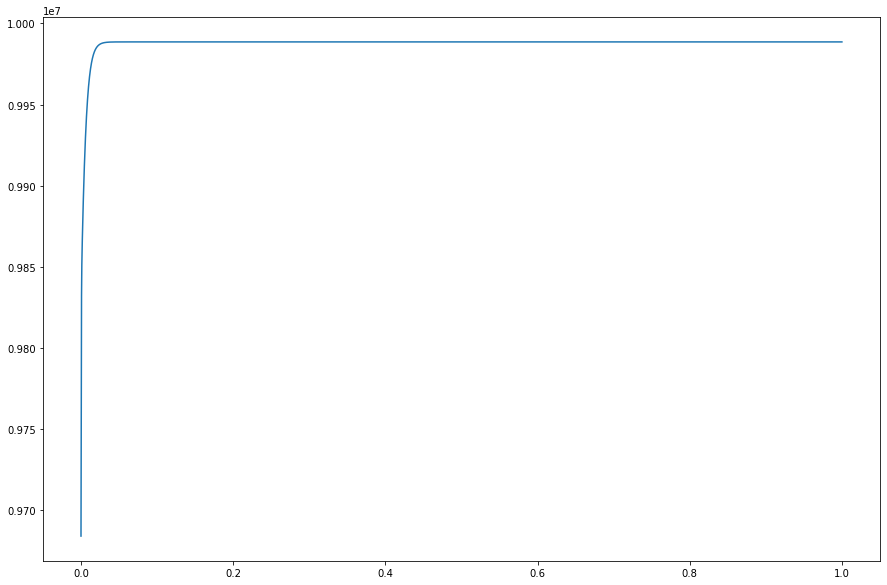

In [19]:
plt.plot(_11specie.sol_x, _11specie.sol_e)

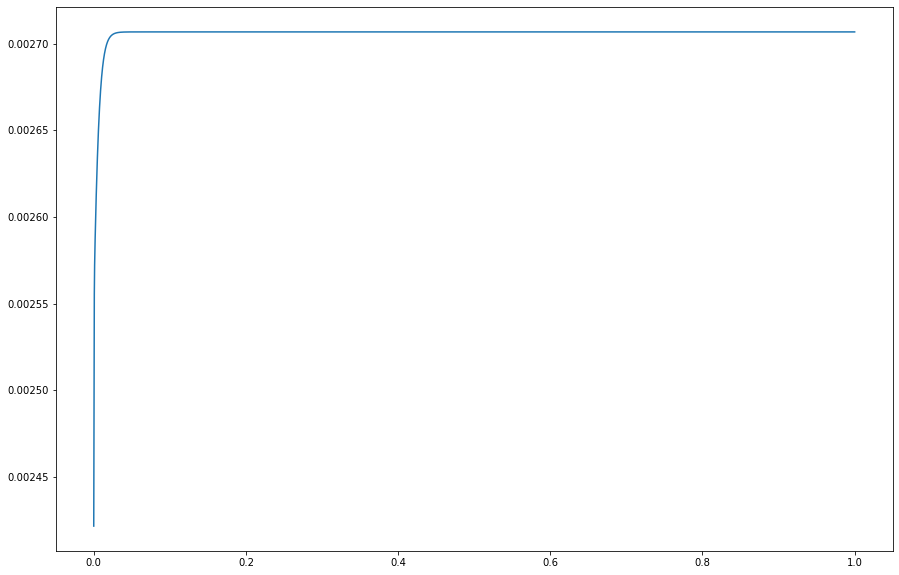

In [20]:
ax = plt.axes()
ax.plot(_11specie.sol_x, _11specie.sol_rho)


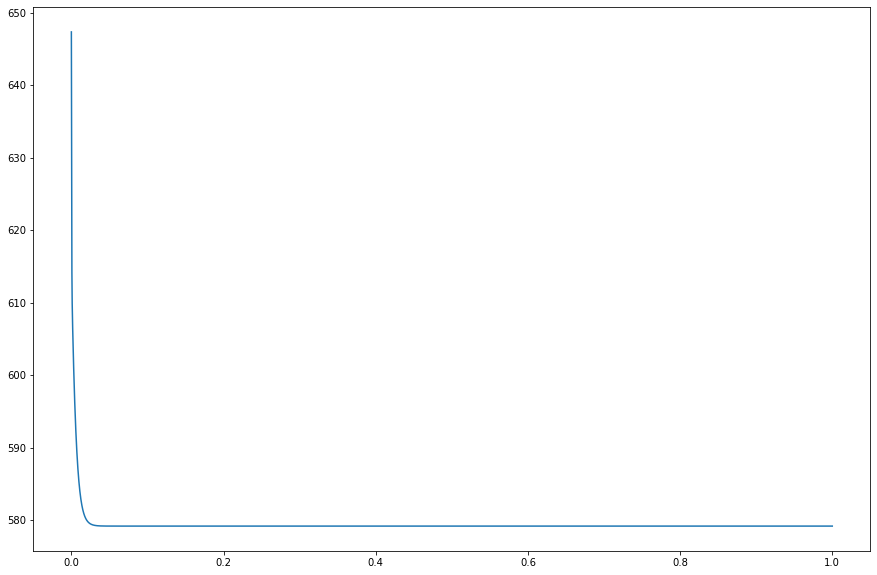

In [21]:
ax = plt.axes()
ax.plot(_11specie.sol_x, _11specie.sol_u)

#ax.set_ylim(300, 500)

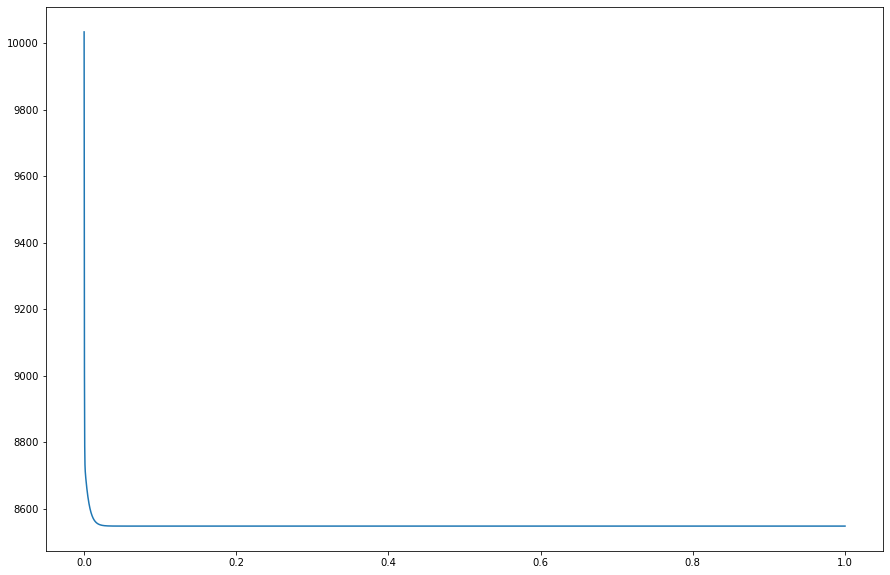

In [22]:
ax = plt.axes()
ax.plot(_11specie.sol_x, _11specie.sol_T)
#ax.set_ylim(3900, 4000)

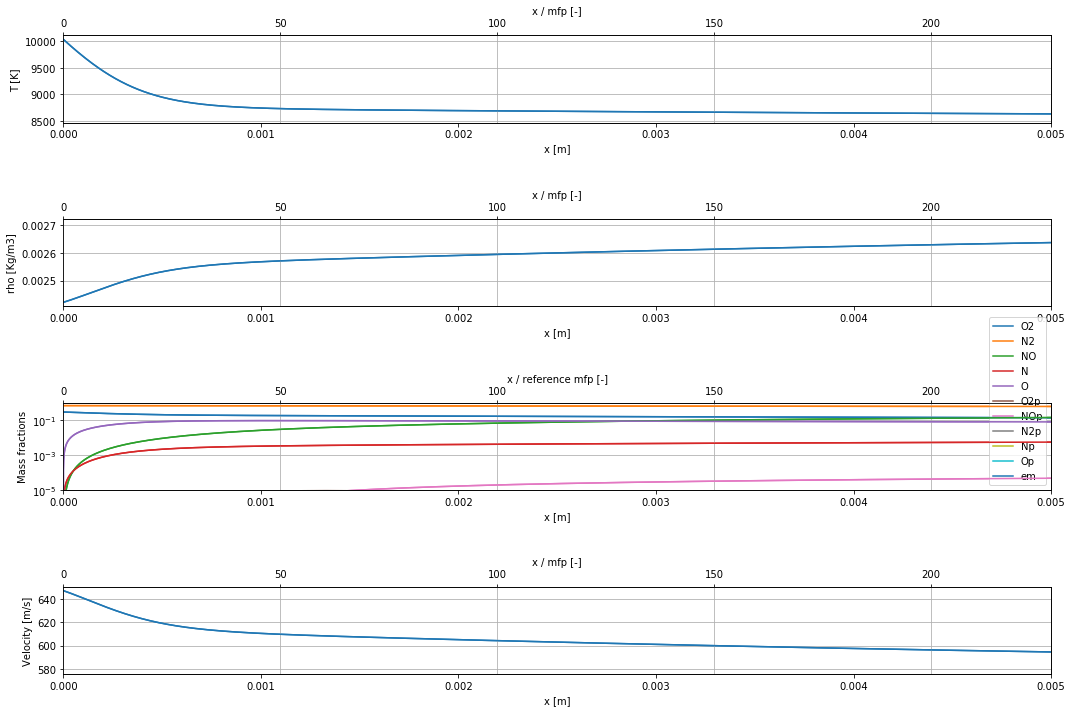

In [23]:
xmax = 5e-3
xmax_l = 3e7

fig, ax = plt.subplots(4, 1,)
_11specie.plot_T(ax[0], xmax = xmax)
_11specie.plot_rho(ax[1], xmax = xmax)
# ax[1].set_ylim(2.2e-3,2.6e-3)
_11specie.logplot_Y(ax[2], xmax = xmax)
_11specie.plot_u(ax[3], xmax = xmax)

fig.tight_layout()

Maximum mass flux error       : 7.275753731159467e-12
Maximum momentum flux error   : 2.1792500046093314e-11
Maximum energy flux error     : 0.02654209564373717
Maximum mass frac error       : 7.205347429817266e-14
Last value of mass flux       : 1.5677014000078964
Ymin                          : -3.9880192698389437e-29


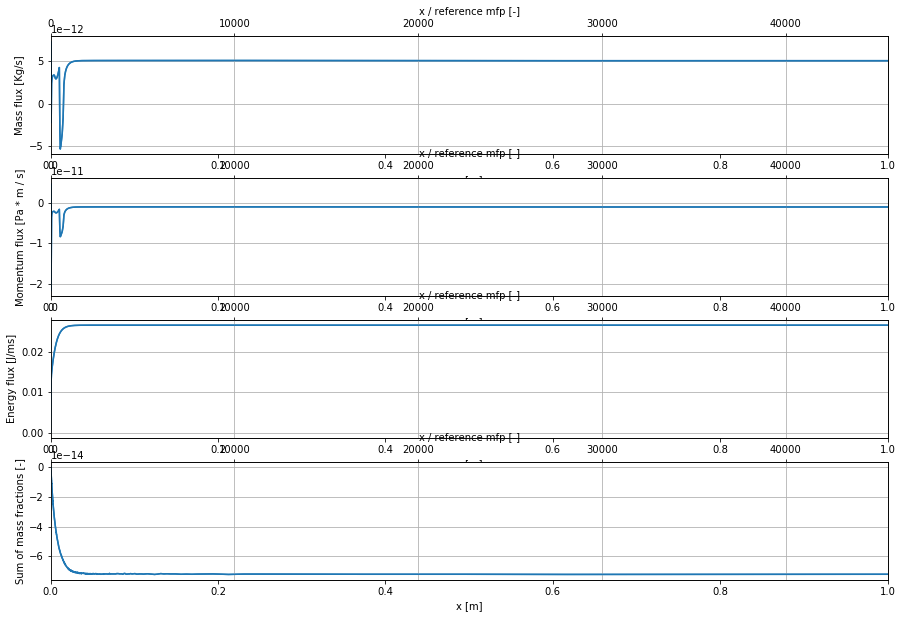

In [34]:
_11specie.validate()

## Effect of altitude (density)

## Effect of velocity

## Effect of composition

# O2 Dissociation

In [25]:
O2_dissociation = problem()

diss = reaction([1.335, -4.127, -0.616, 0.093, -0.005], -117.98*4184)
diss.add_subreaction(subreaction([O2, O], [O, O], [1, 1], [2,1], 8.25e19/1e6,
                                  -1, 59500))

diss.add_subreaction(subreaction([O2, O2], [O, O2], [1, 1], [2,1], 2.75e19/1e6,
                                  -1, 59500))

# Add species 
O2_dissociation.add_specie_ic(O2, 1.0)
O2_dissociation.add_specie_ic(O,  0.0)


# Add reactions
O2_dissociation.reaction.append(diss)

# Set ic
#O2_dissociation.T0     = 273.15 - 74.51
#O2_dissociation.rho0   = 1.8460e-5
#O2_dissociation.u0     = 25*np.sqrt(1.4*Ru/32*O2_dissociation.T0)
O2_dissociation.T0     = 273.15 - 74.51
O2_dissociation.rho0   = 1.8460e-5
O2_dissociation.u0     = 25 * np.sqrt(1.4 * Ru / (32*1e-3) * O2_dissociation.T0)

# Solve
O2_dissociation.solve(xf = 1)

Pre shock Mach : 24.99953124560539
******************************
Post-shock guess values:
rho    : 0.00010988091967707133
T      : 24326.932817927933
Speed  : 1128.987418452406
Mach   : 0.37951675314028627
******************************
Post-shock values:
rho    : 0.00016523198924164306
T      : 17270.44435333903
Speed  : 750.7878856434476
Mach   : 0.32017600476040375
******************************
Reference mean free path : 0.00040063369246117354
Solving for x = 0.000000000000e+00
Solving for x = 0.000000000000e+00
Solving for x = 0.000000000000e+00
Solving for x = 0.000000000000e+00
Solving for x = 0.000000000000e+00
Solving for x = 0.000000000000e+00
Solving for x = 0.000000000000e+00
Solving for x = 0.000000000000e+00
Solving for x = 4.006336924612e-06
Solving for x = 4.006336924612e-06
Solving for x = 4.006336924612e-06
Solving for x = 4.006336924612e-06
Solving for x = 4.006336924612e-06
Solving for x = 4.006336924612e-06
Solving for x = 4.006336924612e-06
Solving for x = 4.0063

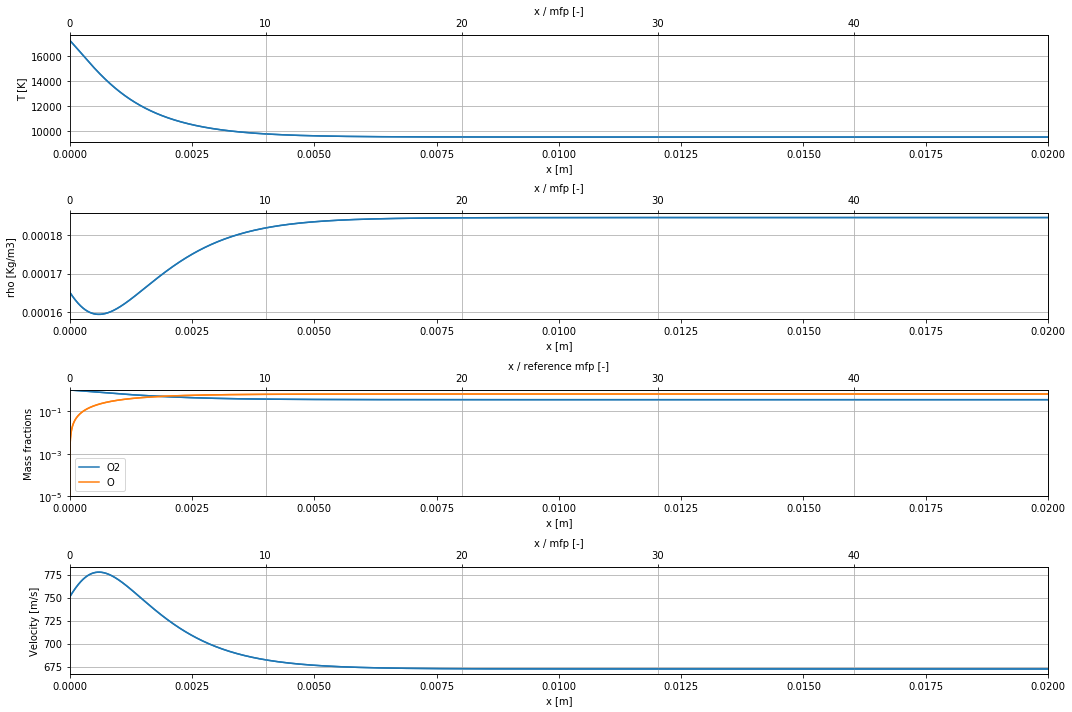

In [26]:
xmax = 2e-2
xmax_l = 3e7

fig, ax = plt.subplots(4, 1,)
O2_dissociation.plot_T(ax[0], xmax = xmax)
# ax[0].set_ylim(5e3,17500)

O2_dissociation.plot_rho(ax[1], xmax = xmax)
#ax[1].set_ylim(1.8e-3,5e-3)
O2_dissociation.logplot_Y(ax[2], xmax = xmax)
O2_dissociation.plot_u(ax[3], xmax = xmax)

fig.tight_layout()

Maximum mass flux error       : 1.925630662959849e-11
Maximum momentum flux error   : 3.279715943028113e-11
Maximum energy flux error     : 9.610604150891136e-05
Maximum mass frac error       : 1.1102230246251565e-15
Last value of mass flux       : 0.12405417584222878
Ymin                          : 0.0


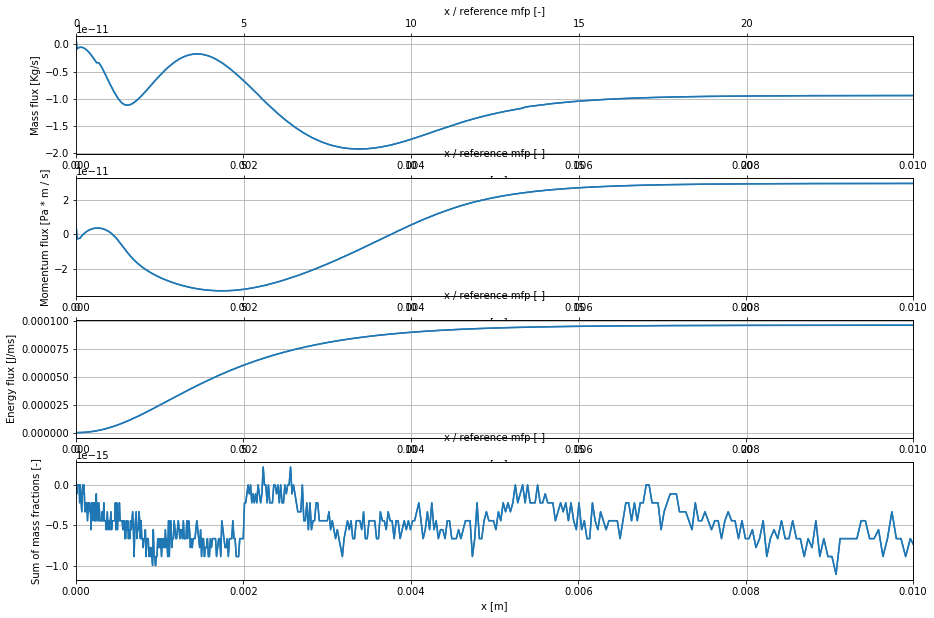

In [32]:
O2_dissociation.validate(xmax=1e-2)